# Кластеризация: разбор K-Means

Разберем **K Means Кластеризацию**, которая является методом *обучения без учителя*.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

##  K-Means

K Means - алгоритм **кластеризации без учителя**, то есть, поиска кластеров в данных только на основании их признаков (без меток классов).

Алгоритм K Means находит центроиды кластеров, которые являются средним значением точек внутри кластера, и все точки внутри кластера находятся в окрестности его центроида.

Посмотрим, как KMeans ведет себя на примере простых кластеров.

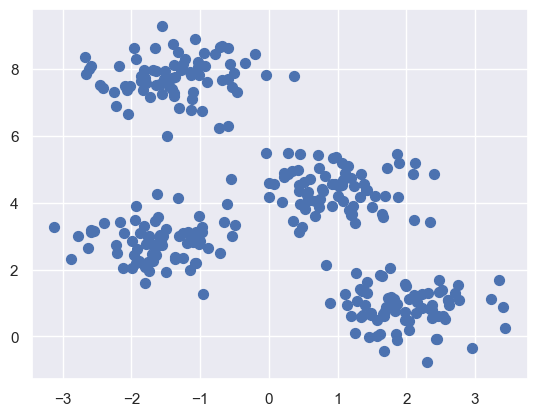

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

На глаз достаточно легко выделить четыре кластера. Однако, простой перебор различных сегментаций данных будет экспоненциально сложным относительно количества точек в датасете. KMeans решает эту задачу достаточно легко.

/Users/mariamitrankova/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


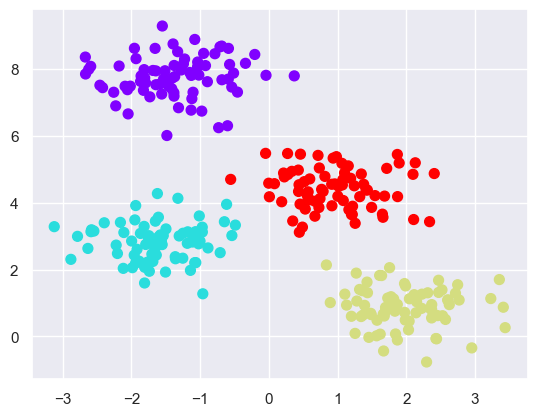

In [3]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

Алгоритм находит 4 кластера похожим образом, как мы определили их на глаз.

## The K-Means Algorithm: Expectation Maximization

Алгоритм K-Means по сути представляет собой двухшаговый алгоритм, который выглядит следующим образом:

1. Определим центроиды как угодно
2. Пока не сошлись:
   A. Распределим точки по кластерам, в зависимости от близости к центроидам
   B. Сдвинем центроиды каждого из кластеров относительно среднего по точкам внутри него
   
Визуализируем данный процесс:

In [4]:
def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    from IPython.html.widgets import interact, IntSlider
    from sklearn.metrics.pairwise import euclidean_distances
    from sklearn.datasets import make_blobs
    import warnings
    warnings.filterwarnings('ignore')

    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=0.60)

    def _kmeans_step(frame=0, n_clusters=4):
        rng = np.random.RandomState(2)
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, 2)

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                dist = euclidean_distances(X, centers)
                labels = dist.argmin(1)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0)
                                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]


        # plot the data and cluster centers
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='rainbow',
                    vmin=0, vmax=n_clusters - 1);
        plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                    c=np.arange(n_clusters),
                    s=200, cmap='rainbow')
        plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                    c='black', s=50)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i],
                             arrowprops=dict(arrowstyle='->', linewidth=1))
            plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c=np.arange(n_clusters),
                        s=200, cmap='rainbow')
            plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c='black', s=50)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                     ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                     ha='right', va='top', size=14)


    return interact(_kmeans_step, frame=IntSlider(min=0, max=50, step=1, value=0),
                    n_clusters=range(min_clusters, max_clusters))

In [5]:
plot_kmeans_interactive()

/Users/mariamitrankova/opt/anaconda3/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


interactive(children=(IntSlider(value=0, description='frame', max=50), Dropdown(description='n_clusters', inde…

<function __main__.plot_kmeans_interactive.<locals>._kmeans_step(frame=0, n_clusters=4)>

Алгоритм будет сходится (в основном) к оптимальным центрам кластеров.

У алгоритма KMeans нет гарантии сходимости. Поэтому, sklearn использует по дефолту множество рандомных инициализаций и выбирает лучшую из них.

К тому же, число кластеров необходимо фиксировать заранее. Существуют другие алгоритмы кластеризации, для которых это необязательно (например, DBScan)

## Применение KMeans к DIGITS

Для более наглядного примера, возьмем датасет рукописных цифр. Применим к нему KMeans, автоматически скластеризуем данные на 10 кластеров по 64 размерностям. Посмотрим, какие центроиды определил данный алгоритм.

In [6]:
from sklearn.datasets import load_digits
digits = load_digits()

In [7]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

Визуализируем каждый кластер, чтобы посмотреть, что он собой представляет:

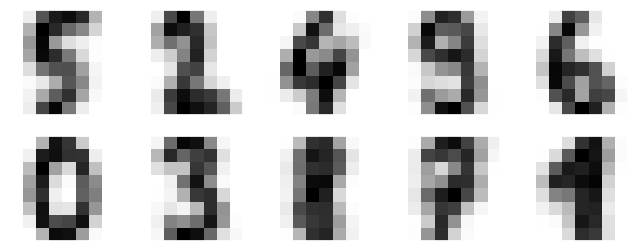

In [8]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

Видим, что *даже без знания о метках классов* KMeans способен определить кластера, чьи средние - узнаваемые цифры (кроме разве что числа 8)

Сделаем так, чтобы номера кластеров совпадали со значением цифры:

In [9]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [10]:
mode(digits.target[clusters == 0])[0]

5

Посмотрим, насколько точен наш KMeans классификатор **без информации о метках:**

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7929883138564274

80% – неплохо! Построим confusion matrix:

[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 147  13   0   0   0   4   8   2]
 [  0   0   0 154   0   2   0   7   7  13]
 [  0   5   0   0 164   0   0   9   3   0]
 [  0   0   0   0   2 136   1   0   0  43]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0   2   0   0   0   0   0 175   2   0]
 [  0   6   3   2   0   4   2   5 101  51]
 [  0  20   0   6   0   6   0   7   2 139]]


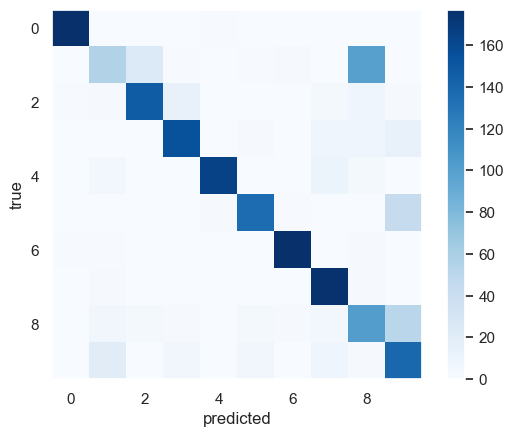

In [12]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(digits.target, labels))

plt.imshow(confusion_matrix(digits.target, labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

Получили в некотором роде **классификатор без учителя**.

## Пример: KMeans для сжатия цветов в изображении

Одним из интересных применений кластеризации является сжатие цветов в изображении. Допустим, у нас есть изображение, содержащее миллионы различных цветов. Для большинства изображений многие из этих цветов не будут использованы, и большое число пикселей будут иметь практически идентичные цвета.

В Scikit-learn есть большой набор изображений, на которых можно экспериментировать. Например:

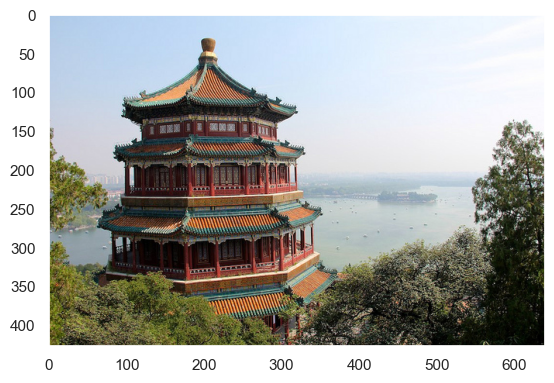

In [13]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.imshow(china)
plt.grid(False);

Изображение представляет собой 3-х мерный массив, размера ``(height, width, RGB)``:

In [14]:
china.shape

(427, 640, 3)

Мы можем представить изображение как облако точек в трехмерном цветовом пространстве. Для удобства отмасштабируем цвета по каналам в пределы от 0 до 1, а затем изменим размер массива на стандартный двумерный, подходящий для scikit-learn:

In [15]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


Получили 273,280 точек с 3 признаками.

Наша задача - используя KMeans перейти от $256^3$ возможных цветов к меньшему количеству (скажем, 64 цвета). Фактически, мы хотим найти $N_{color}$ кластеров в датасете, и создать новое изображение, в котором реальный цвет будет заменен на цвет своего кластера.

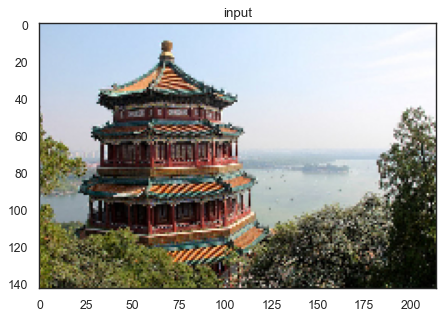

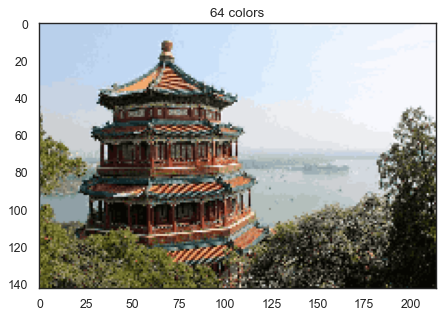

In [16]:
# reduce the size of the image for speed
image = china[::3, ::3]
n_colors = 64

X = (image / 255.0).reshape(-1, 3)

model = KMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(image.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with sns.axes_style('white'):
    plt.figure(dpi=80)
    plt.imshow(image)
    plt.title('input')

    plt.figure(dpi=80)
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))

Таким образом, мы сократили $256^3$ цветов до всего лишь 64.